In [377]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib
import helper_functions.utils as utils
import helper_functions.plot_utils
import helper_functions.routing.driving
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving

In [212]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Singapore", "country": "Singapore"}
network_type = "drive"
trip_times = [15,30,45,60,90]  # in minutes
trip_times = [i*60 for i in trip_times] # in seconds
trip_times
# speed limit is 50 km/h unless otherwise stated
# school zones = 40 km/h
# silver zones for senior pedestrians = 30 - 40 km/h
# expressway = 70 - 90 km/h for cars; 60 km/h for buses
# tunnels = 50 - 80 km/h, depending on vehicle type

[900, 1800, 2700, 3600, 5400]

# Plot/save drive network


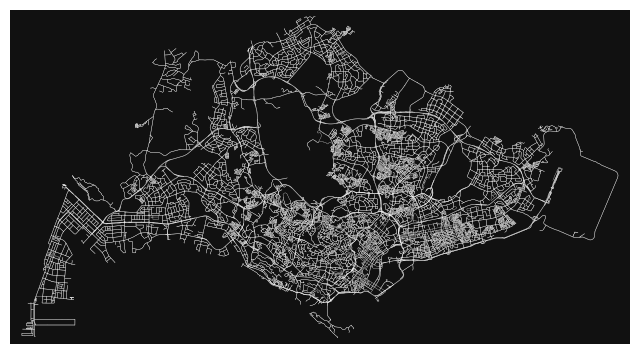

In [3]:
# # download/model a street network for some city then visualize it
# G_drive = ox.graph_from_place(place, network_type=network_type)

# # # save driving network
save_dir = os.path.join(os.getcwd(),"data")
# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)
filename = "SG_drive_network.graphml"
# # save graph to disk as GraphML file
# ox.save_graphml(G_drive, filepath=os.path.join(save_dir,filename))

# load graph from disk
G_drive = ox.load_graphml(os.path.join(save_dir,filename))
fig, ax = ox.plot_graph(G_drive, node_size=0, edge_color="w", edge_linewidth=0.2)

# Inspect speed limits

In [7]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_drive, nodes=False)
edges.head()

osmid  \
u        v          key                                                      
25451929 6749812859 0    [49961799, 718881456, 741164883, 754786742, 17...   
25455287 1637003462 0                                            150829205   
         2521018789 0                     [633215386, 74607482, 635109319]   
26777521 172424179  0                    [481674707, 654734557, 633179143]   
         1889379421 0         [643413273, 559564482, 640203517, 640203518]   

                               highway   lanes maxspeed  \
u        v          key                                   
25451929 6749812859 0         motorway       5       70   
25455287 1637003462 0    motorway_link       1       50   
         2521018789 0         motorway  [2, 3]       90   
26777521 172424179  0          primary       2       40   
         1889379421 0      residential       2       50   

                                                  name  oneway  ref reversed  \
u        v          key                                                        
25451929 6749812859 0               East Coast Parkway    True  ECP    False   
25455287 1637003462 0    Kallang Paya Lebar Expressway    True  NaN    False   
         2521018789 0               East Coast Parkway    True  ECP    False   
26777521 172424179  0                      Grange Road    True  NaN    False   
         1889379421 0                    Cuscaden Road   False  NaN    False   

                             length bridge  \
u        v          key                      
25451929 6749812859 0    765.027747    yes   
25455287 1637003462 0    629.055082    NaN   
         2521018789 0    652.575579    NaN   
26777521 172424179  0    113.995770    NaN   
         1889379421 0     86.667744    NaN   

                                                                  geometry  \
u        v          key                                                      
25451929 6749812859 0    LINESTRING (103.87254 1.29523, 103.87103 1.295...   
25455287 1637003462 0    LINESTRING (103.874 1.29544, 103.87413 1.2955,...   
         2521018789 0    LINESTRING (103.874 1.29544, 103.87438 1.29544...   
26777521 172424179  0    LINESTRING (103.82357 1.30398, 103.82359 1.303...   
         1889379421 0    LINESTRING (103.82357 1.30398, 103.82372 1.304...   

                        tunnel junction access width  
u        v          key                               
25451929 6749812859 0      NaN      NaN    NaN   NaN  
25455287 1637003462 0      NaN      NaN    NaN   NaN  
         2521018789 0      NaN      NaN    NaN   NaN  
26777521 172424179  0      NaN      NaN    NaN   NaN  
         1889379421 0      NaN      NaN    NaN   NaN

In [6]:
edges[edges['maxspeed'].isna()]

osmid  \
u           v           key                                                      
237296759   249799919   0    [480746656, 174552487, 167648620, 25864563, 48...   
237420004   11385801833 0                                           1125141703   
239701951   12213144214 0                                           1319768709   
            12213144223 0                                           1319768709   
240002104   2598074293  0                                            253945337   
...                                                                        ...   
9658768591  9658768592  0                                           1051060329   
9658768592  9658768594  0                                           1051060329   
10806629050 2325064861  0                                            223626312   
11829817082 11829817077 0                                           1273997441   
12005108712 12005108716 0                                           1295550998   

                                  highway   lanes maxspeed  \
u           v           key                                  
237296759   249799919   0        motorway  [4, 3]      NaN   
237420004   11385801833 0     residential     NaN      NaN   
239701951   12213144214 0        tertiary       2      NaN   
            12213144223 0        tertiary       2      NaN   
240002104   2598074293  0        tertiary       2      NaN   
...                                   ...     ...      ...   
9658768591  9658768592  0        tertiary     NaN      NaN   
9658768592  9658768594  0        tertiary     NaN      NaN   
10806629050 2325064861  0     residential     NaN      NaN   
11829817082 11829817077 0    primary_link     NaN      NaN   
12005108712 12005108716 0     residential     NaN      NaN   

                                               name  oneway  ref reversed  \
u           v           key                                                 
237296759   249799919   0        Central Expressway    True  CTE    False   
237420004   11385801833 0       Holland Village Way    True  NaN    False   
239701951   12213144214 0    South Buona Vista Road   False  NaN    False   
            12213144223 0    South Buona Vista Road   False  NaN     True   
240002104   2598074293  0           Commerce Street   False  NaN    False   
...                                             ...     ...  ...      ...   
9658768591  9658768592  0    Tanah Merah Coast Road    True  NaN    False   
9658768592  9658768594  0    Tanah Merah Coast Road    True  NaN    False   
10806629050 2325064861  0                       NaN   False  NaN     True   
11829817082 11829817077 0                       NaN    True  NaN    False   
12005108712 12005108716 0                       NaN    True  NaN    False   

                                 length bridge  \
u           v           key                      
237296759   249799919   0    537.198578    NaN   
237420004   11385801833 0      7.759250    NaN   
239701951   12213144214 0     41.585428    NaN   
            12213144223 0    277.824087    NaN   
240002104   2598074293  0     60.566671    NaN   
...                                 ...    ...   
9658768591  9658768592  0     70.488473    NaN   
9658768592  9658768594  0    393.334773    NaN   
10806629050 2325064861  0     46.676889    NaN   
11829817082 11829817077 0     29.249508    NaN   
12005108712 12005108716 0     24.343332    NaN   

                                                                      geometry  \
u           v           key                                                      
237296759   249799919   0    LINESTRING (103.84205 1.28912, 103.84184 1.288...   
237420004   11385801833 0    LINESTRING (103.79264 1.31122, 103.79271 1.31123)   
239701951   12213144214 0    LINESTRING (103.78748 1.2822, 103.78735 1.2820...   
            12213144223 0    LINESTRING (103.78748 1.2822, 103.78769 1.2823...   
240002104   2598074293  0    LINESTRING (103.85056 1.2

## Check if edges lie within school zones or silver zones

In [11]:
SchoolZones = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\SchoolZone_Nov2024\SCHOOLZONE.shp")
print(SchoolZones.crs)
SchoolZones = SchoolZones.to_crs(edges.crs)
print(SchoolZones.crs)
SchoolZones.head()

PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
epsg:4326


,SITENAME,INC_CRC,FMEL_UPD_D,geometry
0,Tampines North Primary School,F3A9A20A,2016-03-29,"POLYGON ((103.94872 1.36007, 103.94894 1.36001..."
1,Chij (Katong) Primary School,54B7FF5E,2016-03-29,"POLYGON ((103.91083 1.30752, 103.91106 1.30692..."
2,Metta School,2B880636,2016-03-29,"POLYGON ((103.95627 1.34661, 103.9578 1.34649,..."
3,Opera Estate Primary School,A838D0F7,2016-03-29,"POLYGON ((103.92235 1.31926, 103.9225 1.31925,..."
4,Minds-Towner Gdns School,86AC26B3,2016-03-29,"POLYGON ((103.91371 1.32708, 103.91372 1.32681..."


In [12]:
SilverZones = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\SilverZone_Nov2024\SILVERZONE.shp")
print(SilverZones.crs)
SilverZones = SilverZones.to_crs(edges.crs)
print(SilverZones.crs)
SilverZones.head()

PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
epsg:4326


,SITENAME,INC_CRC,FMEL_UPD_D,geometry
0,TECK WHYE LANE,D9DA16AB69A7035F,2024-01-07,"POLYGON ((103.75238 1.37963, 103.75222 1.37961..."
1,CHAI CHEE ROAD,3BD0A7504BF9921B,2024-01-07,"POLYGON ((103.92315 1.32282, 103.92317 1.32283..."
2,TELOK BLANGAH CRESCENT,0B38BC5EFC04D840,2024-01-07,"POLYGON ((103.81797 1.2775, 103.81782 1.27774,..."
3,HOUGANG STREET 21,FBADDED03B06EF73,2024-01-07,"POLYGON ((103.8831 1.35814, 103.88309 1.3581, ..."
4,POTONG PASIR AVE 1 & AVE 2,8923AB6D26C7F1BE,2024-01-07,"POLYGON ((103.86649 1.33147, 103.86652 1.33146..."


In [49]:
# print(len(SchoolZones.index))
# print(len(SilverZones.index))
def get_roads_within_zones(specialZones,roads):
    """ 
    get roads that are within school zones/silver zones
    Args:
        specialZones (gdf): gdf of zones in Polygons
        roads (gdf): roads that are represented in the form of ox.edges
    Returns:
        edges id: edges' index (u to v)
    """
    edges = []
    for z in specialZones.geometry: # Polygon
        rd = roads[roads.geometry.within(z)] # subset roads that lie within Polygons
        edges.append(rd)

    return pd.concat(edges)

sch_edges = get_roads_within_zones(SchoolZones,edges)
sch_edges



osmid  \
u          v          key                                                      
243679058  992571784  0                                            173767905   
992571784  5015699374 0                                            512991758   
5015699374 5015699375 0                                            512991759   
5015699375 243679058  0                                            512991757   
258306066  1849458079 0                     [737660688, 737660689, 23837148]   
...                                                                      ...   
5950255468 245174809  0                                            630075834   
9080932827 9080932825 0                                            464809797   
           4598816973 0                                            479616490   
4598826810 6244033776 0    [627932386, 536039235, 825713064, 825713065, 8...   
6244033776 5015083863 0                    [825713066, 628007114, 628009023]   

                                  highway   lanes maxspeed  \
u          v          key                                    
243679058  992571784  0       residential     NaN       50   
992571784  5015699374 0         secondary       2       40   
5015699374 5015699375 0       residential     NaN       50   
5015699375 243679058  0         secondary       2       60   
258306066  1849458079 0       residential       4       40   
...                                   ...     ...      ...   
5950255468 245174809  0       residential       2       50   
9080932827 9080932825 0    secondary_link       1       40   
           4598816973 0         secondary       2       40   
4598826810 6244033776 0       residential       1       40   
6244033776 5015083863 0       residential  [2, 1]       40   

                                         name  oneway  ref reversed  \
u          v          key                                             
243679058  992571784  0    Tampines Street 41    True  NaN    False   
992571784  5015699374 0     Tampines Avenue 9    True  NaN    False   
5015699374 5015699375 0    Tampines Street 41    True  NaN    False   
5015699375 243679058  0     Tampines Avenue 9    True  NaN    False   
258306066  1849458079 0       Jalan Kembangan   False  NaN     True   
...                                       ...     ...  ...      ...   
5950255468 245174809  0           Fulton Road   False  NaN     True   
9080932827 9080932825 0                   NaN    True  NaN    False   
           4598816973 0       Sin Ming Avenue    True  NaN    False   
4598826810 6244033776 0       Anchorvale Link    True  NaN    False   
6244033776 5015083863 0       Anchorvale Link    True  NaN    False   

                               length bridge  \
u          v          key                      
243679058  992571784  0     11.288950    NaN   
992571784  5015699374 0      5.492852    NaN   
5015699374 5015699375 0     11.366769    NaN   
5015699375 243679058  0      5.491670    NaN   
258306066  1849458079 0    124.123795    NaN   
...                               ...    ...   
5950255468 245174809  0     11.515708    NaN   
9080932827 9080932825 0     23.817602    NaN   
           4598816973 0     14.976867    NaN   
4598826810 6244033776 0    116.423063    NaN   
6244033776 5015083863 0    115.879692    NaN   

                                                                    geometry  \
u          v          key                                                      
243679058  992571784  0    LINESTRING (103.94932 1.35978, 103.94932 1.35988)   
992571784  5015699374 0    LINESTRING (103.94932 1.35988, 103.94937 1.35988)   
5015699374 5015699375 0    LINESTRING (103.94937 1.35988, 103.94937 1.35978)   
5015699375 243679058  0    LINESTRING (103.94937 1.35978, 103.94932 1.35978)   
258306066  1849458079 0    LINESTRING (103.91349 1.32534, 103.9135 1.3254...   
...                                                                      ...   
5950255468 245174809  0    LINESTR

In [57]:
edges.loc[sch_edges.index,'maxspeed']

u           v           key
243679058   992571784   0      50
992571784   5015699374  0      40
5015699374  5015699375  0      50
5015699375  243679058   0      60
258306066   1849458079  0      40
                               ..
5950255468  245174809   0      50
9080932827  9080932825  0      40
            4598816973  0      40
4598826810  6244033776  0      40
6244033776  5015083863  0      40
Name: maxspeed, Length: 326, dtype: object

In [60]:
edges.loc[sch_edges.index,'maxspeed'] = 40 # sch zone speed limit is 40
edges.loc[sch_edges.index,'maxspeed']

u           v           key
243679058   992571784   0      40
992571784   5015699374  0      40
5015699374  5015699375  0      40
5015699375  243679058   0      40
258306066   1849458079  0      40
                               ..
5950255468  245174809   0      40
9080932827  9080932825  0      40
            4598816973  0      40
4598826810  6244033776  0      40
6244033776  5015083863  0      40
Name: maxspeed, Length: 326, dtype: object

In [62]:
silver_edges = get_roads_within_zones(SilverZones,edges)
silver_edges

osmid  \
u          v          key                                                      
243713498  243713550  0    [644243460, 631905521, 669863123, 631889045, 6...   
243713550  243713498  0    [644243460, 631905521, 669863123, 631889045, 6...   
           4945784620 0    [632829888, 676155366, 22721849, 640182778, 64...   
4945784620 243713550  0    [632829888, 676155366, 22721849, 640182778, 64...   
2238840352 5599434282 0                                            644417768   
...                                                                      ...   
4753394967 4753394968 0                                            537120322   
4753394968 4753394965 0                                            482534353   
5178982356 5178982357 0                                            482522726   
5178982357 4740612730 0                                            537120324   
           905160623  0    [639906946, 537120323, 644974469, 644987913, 4...   

                               highway   lanes maxspeed  \
u          v          key                                 
243713498  243713550  0    residential       2       50   
243713550  243713498  0    residential       2       50   
           4945784620 0    residential       2       50   
4945784620 243713550  0    residential       2       50   
2238840352 5599434282 0    residential     NaN      NaN   
...                                ...     ...      ...   
4753394967 4753394968 0       tertiary       2       40   
4753394968 4753394965 0    residential       1       40   
5178982356 5178982357 0    residential       1       40   
5178982357 4740612730 0       tertiary       3       50   
           905160623  0    residential  [2, 1]       40   

                                            name  oneway  ref reversed  \
u          v          key                                                
243713498  243713550  0           Teck Whye Lane   False  NaN    False   
243713550  243713498  0           Teck Whye Lane   False  NaN     True   
           4945784620 0           Teck Whye Lane   False  NaN    False   
4945784620 243713550  0           Teck Whye Lane   False  NaN     True   
2238840352 5599434282 0         Chai Chee Avenue   False  NaN    False   
...                                          ...     ...  ...      ...   
4753394967 4753394968 0    Jurong West Street 51    True  NaN    False   
4753394968 4753394965 0    Jurong West Street 52    True  NaN    False   
5178982356 5178982357 0    Jurong West Street 52    True  NaN    False   
5178982357 4740612730 0     Jurong West Avenue 1    True  NaN    False   
           905160623  0    Jurong West Street 52    True  NaN    False   

                               length bridge  \
u          v          key                      
243713498  243713550  0    365.345939    NaN   
243713550  243713498  0    365.345939    NaN   
           4945784620 0    131.032923    NaN   
4945784620 243713550  0    131.032923    NaN   
2238840352 5599434282 0      3.503509    NaN   
...                               ...    ...   
4753394967 4753394968 0      8.687099    NaN   
4753394968 4753394965 0      7.274105    NaN   
5178982356 5178982357 0      8.079521    NaN   
5178982357 4740612730 0      9.467593    NaN   
           905160623  0    825.919130    NaN   

                                                                    geometry  \
u          v          key                                                      
243713498  243713550  0    LINESTRING (103.7525 1.37967, 103.75251 1.3796...   
243713550  243713498  0    LINESTRING (103.75464 1.37812, 103.75462 1.378...   
           4945784620 0    LINESTRING (103.75464 1.37812, 103.75464 1.378...   
4945784620 243713550  0    LINESTRING (103.75475 1.37695, 103.75474 1.377...   
2238840352 5599434282 0      LINESTRING (103.9232 1.3253, 103.92324 1.32529)   
...                                                                      ...   
4753394967 4753394968 0    LINESTR

In [73]:
edges.loc[silver_edges.index,'maxspeed'] = 40 # silver zones for senior pedestrians = 30 - 40 km/h, but just take the upper limit
edges.loc[silver_edges.index,'maxspeed']

u           v           key
243713498   243713550   0      40
243713550   243713498   0      40
            4945784620  0      40
4945784620  243713550   0      40
2238840352  5599434282  0      40
                               ..
4753394967  4753394968  0      40
4753394968  4753394965  0      40
5178982356  5178982357  0      40
5178982357  4740612730  0      40
            905160623   0      40
Name: maxspeed, Length: 219, dtype: object

### Identify non-numeric values in maxspeed

In [100]:
null_index = edges[~pd.to_numeric(edges.maxspeed, errors='coerce').notnull()].index
edges.loc[null_index,:]

,,,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,bridge,geometry,tunnel,junction,access,width
u,v,key,,,,,,,,,,,,,,,
139642419,4728054624,0,"[479174082, 479174083, 74628616, 479757261, 15...",motorway,3,"[80, 90]",Pan-Island Expressway,True,PIE,False,523.640401,yes,"LINESTRING (103.8799 1.32008, 103.87966 1.32, ...",NaN,NaN,NaN,NaN
141883271,566224675,0,"[480749315, 480749316, 480749319, 480749320, 4...",motorway,3,"[80, 90]",Ayer Rajah Expressway,True,AYE,False,2546.445190,NaN,"LINESTRING (103.82015 1.27899, 103.81924 1.279...",NaN,NaN,NaN,NaN
172517972,1931968476,0,"[649336169, 302367561, 639902539, 649957995, 7...","[trunk_link, tertiary]",2,"[50, 40]",Stadium Road,True,NaN,False,760.029468,yes,"LINESTRING (103.87021 1.3055, 103.8706 1.30584...",NaN,NaN,NaN,NaN
232105452,2015361448,0,"[173779737, 826342061, 639881927]",secondary,3,"[50, 40]",Jalan Sultan,True,NaN,False,207.761368,NaN,"LINESTRING (103.86081 1.3042, 103.86086 1.3041...",NaN,NaN,NaN,NaN
237054768,12071463880,0,"[35037538, 528539591, 459186769, 173779730, 35...",trunk,"[5, 4]","[70, 60]","[Fullerton Road, Esplanade Drive]",True,NaN,False,541.885182,yes,"LINESTRING (103.85371 1.28639, 103.85376 1.286...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658768591,9658768592,0,1051060329,tertiary,NaN,NaN,Tanah Merah Coast Road,True,NaN,False,70.488473,NaN,"LINESTRING (104.00425 1.31215, 104.00424 1.312...",NaN,NaN,NaN,NaN
9658768592,9658768594,0,1051060329,tertiary,NaN,NaN,Tanah Merah Coast Road,True,NaN,False,393.334773,NaN,"LINESTRING (104.00448 1.3127, 104.00719 1.3145...",NaN,NaN,NaN,NaN
10806629050,2325064861,0,223626312,residential,NaN,NaN,NaN,False,NaN,True,46.676889,NaN,"LINESTRING (103.90744 1.30722, 103.90709 1.30699)",NaN,NaN,NaN,NaN


### Replace NA values

In [108]:
na_speeds = edges[~pd.to_numeric(edges.maxspeed, errors='coerce').notnull()]['maxspeed']
def get_max_speed(speed_list, replace_na = 50):
    """ Converts str to float then select max speed
    Args:
        speed_list (list of str or np.NaN): sometimes in OSM, the max speed is described as a list of str
        replace_na (float): replace np.NaN values with a float value. Default speed limit is 50 km/h
    Returns:
        float: max speed
    """
    if isinstance(speed_list, list):
        return max([float(s) for s in speed_list])
    elif np.isnan(speed_list):
        return replace_na
    else:
        return np.nan

na_speeds = na_speeds.apply(get_max_speed)
# replace NA rows with updated values
edges.loc[null_index,'maxspeed'] = na_speeds
edges.loc[null_index,'maxspeed']

u            v            key
139642419    4728054624   0      90.0
141883271    566224675    0      90.0
172517972    1931968476   0      50.0
232105452    2015361448   0      50.0
237054768    12071463880  0      70.0
                                 ... 
9658768591   9658768592   0      50.0
9658768592   9658768594   0      50.0
10806629050  2325064861   0      50.0
11829817082  11829817077  0      50.0
12005108712  12005108716  0      50.0
Name: maxspeed, Length: 2685, dtype: object

# Visualise edge maxspeed

In [116]:
# check if there are NAs or nulls in maxspeed
print('Number of nulls/NAs: ',len(edges[~pd.to_numeric(edges.maxspeed, errors='coerce').notnull()]['maxspeed'].index))
print('Are there no NAs? ',edges['maxspeed'].notna().all())
print('Are there no nulls? ',edges['maxspeed'].notnull().all())
# convert dtype object to numeric
edges['maxspeed'] = pd.to_numeric(edges['maxspeed'])
print(edges.dtypes)
print('Are there no NAs? ',edges['maxspeed'].notna().all())
print('Are there no nulls? ',edges['maxspeed'].notnull().all())

Number of nulls/NAs:  0
Are there no NAs?  True
Are there no nulls?  True
osmid         object
highway       object
lanes         object
maxspeed     float64
name          object
oneway          bool
ref           object
reversed      object
length       float64
bridge        object
geometry    geometry
tunnel        object
junction      object
access        object
width         object
dtype: object
Are there no NAs?  True
Are there no nulls?  True


### Replace maxspeed attributes with the updated one

In [134]:
print('Does the number of edges match? ',len(G_drive.edges()) == len(edges.index))
for (_, _, _, data),maxspeed in zip(G_drive.edges(data=True, keys=True),edges['maxspeed']):
    data['maxspeed'] = maxspeed

Does the number of edges match?  True


# Visualise roads' maxspeed limit

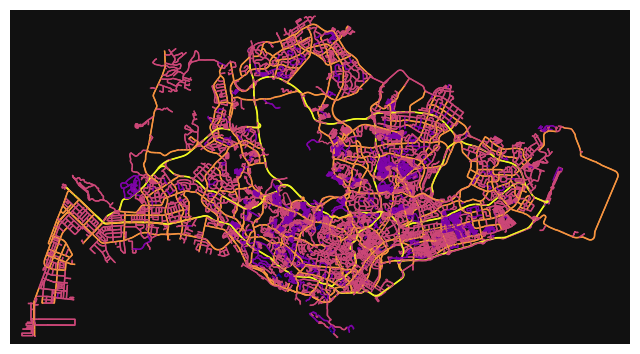

In [195]:
# get node colors by linearly mapping an attribute's values to a colormap
ec = ox.plot.get_edge_colors_by_attr(G_drive, attr="maxspeed", cmap='plasma',num_bins=5)
# fig, ax = ox.plot_graph(G_drive, node_size=0, edge_color=ec, bgcolor="white")
# plot the graph with colored edges
fig, ax = ox.plot_graph(G_drive, node_size=0, edge_color=ec)

In [196]:
ec_colors = pd.concat([edges['maxspeed'],ec],axis=1).groupby(0)['maxspeed'].apply(lambda x: f'{x.min()}-{x.max()} km/h').reset_index()
ec_colors

,0,maxspeed
0,#0d0887,10.0-25.0 km/h
1,#7e03a8,30.0-40.0 km/h
2,#cc4778,50.0-50.0 km/h
3,#f0f921,80.0-90.0 km/h
4,#f89540,60.0-70.0 km/h


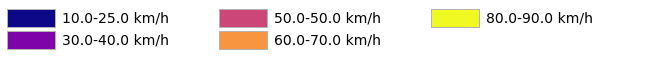

In [200]:
# hex colors are stored in the column 0, maxspeed labels are stored in the column maxspeed
plot_utils.plot_colortable(ec_colors[0], ec_colors['maxspeed'], ncols=3, sort_colors=False)

# Add edge travel times
- `osmnx.routing.add_edge_speeds(G)`
    - By default, this imputes free-flow travel speeds for all edges via the mean *maxspeed* value of the edges of each highway type. 
    - For highway types in the graph that have no maxspeed value on any edge, it assigns the mean of all *maxspeed* values in graph.
    - Returns: Graph with *speed_kph* attributes on all edges
- `osmnx.routing.add_edge_travel_times(G)`
    - Add edge travel time (seconds) to graph as new travel_time edge attributes.
    - Calculates free-flow travel time along each edge, based on length and speed_kph attributes. Note: run `add_edge_speeds` first to generate the speed_kph attribute. All edges must have length and speed_kph attributes and all their values must be non-null.
    - Returns: Graph with *travel_time* attributes on all edges

In [201]:
# impute speed on all edges missing data
G_car = ox.add_edge_speeds(G_drive)

# calculate travel time (seconds) for all edges
G_car = ox.add_edge_travel_times(G_car)

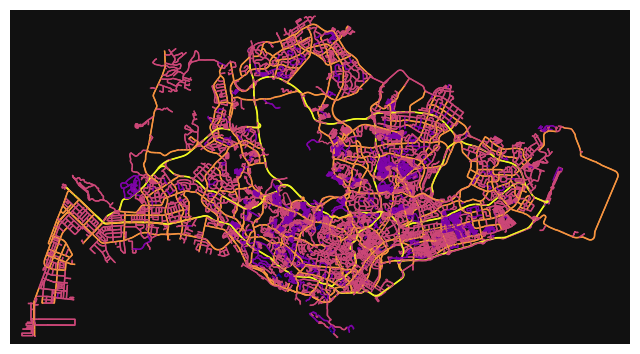

In [202]:
# get node colors by linearly mapping an attribute's values to a colormap
ec = ox.plot.get_edge_colors_by_attr(G_car, attr="speed_kph", cmap='plasma',num_bins=5)
# fig, ax = ox.plot_graph(G_car, node_size=0, edge_color=ec, bgcolor="white")
# plot the graph with colored edges
fig, ax = ox.plot_graph(G_car, node_size=0, edge_color=ec)

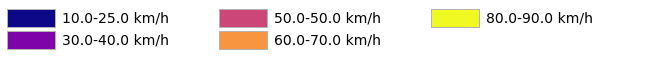

In [203]:
edges = ox.graph_to_gdfs(G_car, nodes=False)
ec_colors = pd.concat([edges['speed_kph'],ec],axis=1).groupby(0)['speed_kph'].apply(lambda x: f'{x.min()}-{x.max()} km/h').reset_index()
# hex colors are stored in the column 0, speed_kph labels are stored in the column speed_kph
plot_utils.plot_colortable(ec_colors[0], ec_colors['speed_kph'], ncols=3, sort_colors=False)

### View speed_kph and travel_time (seconds) by road types

In [204]:
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['motorway_link', 'motorway']",451.0,50.0,32.5
"['motorway_link', 'primary']",379.4,65.0,20.7
"['motorway_link', 'secondary']",461.1,54.0,32.7
"['motorway_link', 'tertiary']",555.8,50.0,40.0
"['primary', 'primary_link']",1368.1,65.0,71.2
"['primary', 'secondary']",271.6,60.0,16.3
"['primary_link', 'secondary']",495.9,50.0,35.7
"['primary_link', 'tertiary']",1300.6,50.0,93.6
"['residential', 'living_street']",231.2,50.0,16.6


### Export car network 
with the updated max speed limit

In [206]:
# # # # save walking network
save_dir = os.path.join(os.getcwd(),"data")
# # if not os.path.exists(save_dir):
# #     os.mkdir(save_dir)
filename = "SG_car_network.graphml"
# # # save graph to disk as GraphML file
# ox.save_graphml(G_car, filepath=os.path.join(save_dir,filename))

G_car = ox.load_graphml(os.path.join(save_dir,filename))

In [207]:
edges = ox.graph_to_gdfs(G_car, nodes=False)
edges.head()

osmid  \
u        v          key                                                      
25451929 6749812859 0    [49961799, 718881456, 741164883, 754786742, 17...   
25455287 1637003462 0                                            150829205   
         2521018789 0                     [633215386, 74607482, 635109319]   
26777521 172424179  0                    [481674707, 654734557, 633179143]   
         1889379421 0         [643413273, 559564482, 640203517, 640203518]   

                               highway   lanes maxspeed  \
u        v          key                                   
25451929 6749812859 0         motorway       5     70.0   
25455287 1637003462 0    motorway_link       1     50.0   
         2521018789 0         motorway  [2, 3]     90.0   
26777521 172424179  0          primary       2     40.0   
         1889379421 0      residential       2     50.0   

                                                  name  oneway  ref reversed  \
u        v          key                                                        
25451929 6749812859 0               East Coast Parkway    True  ECP    False   
25455287 1637003462 0    Kallang Paya Lebar Expressway    True  NaN    False   
         2521018789 0               East Coast Parkway    True  ECP    False   
26777521 172424179  0                      Grange Road    True  NaN    False   
         1889379421 0                    Cuscaden Road   False  NaN    False   

                             length bridge  \
u        v          key                      
25451929 6749812859 0    765.027747    yes   
25455287 1637003462 0    629.055082    NaN   
         2521018789 0    652.575579    NaN   
26777521 172424179  0    113.995770    NaN   
         1889379421 0     86.667744    NaN   

                                                                  geometry  \
u        v          key                                                      
25451929 6749812859 0    LINESTRING (103.87254 1.29523, 103.87103 1.295...   
25455287 1637003462 0    LINESTRING (103.874 1.29544, 103.87413 1.2955,...   
         2521018789 0    LINESTRING (103.874 1.29544, 103.87438 1.29544...   
26777521 172424179  0    LINESTRING (103.82357 1.30398, 103.82359 1.303...   
         1889379421 0    LINESTRING (103.82357 1.30398, 103.82372 1.304...   

                         speed_kph  travel_time tunnel junction access width  
u        v          key                                                       
25451929 6749812859 0         70.0    39.344284    NaN      NaN    NaN   NaN  
25455287 1637003462 0         50.0    45.291966    NaN      NaN    NaN   NaN  
         2521018789 0         90.0    26.103023    NaN      NaN    NaN   NaN  
26777521 172424179  0         40.0    10.259619    NaN      NaN    NaN   NaN  
         1889379421 0         50.0     6.240078    NaN      NaN    NaN   NaN

# Import workplace cluster nodes

In [208]:
workplace_cluster = pd.read_csv(r"data\workplace_cluster.csv")
workplace_cluster

,latitude,longitude
0,1.320935,103.894151
1,1.327584,103.703464
2,1.448092,103.810287
3,1.284441,103.842959
4,1.295068,103.629310
5,1.356448,103.957308
6,1.299561,103.798223
7,1.309864,103.857340
8,1.374454,103.857601
9,1.320213,103.656895


In [332]:
workplace_nodes = ox.distance.nearest_nodes(G_car, X=workplace_cluster.longitude.to_list(), Y=workplace_cluster.latitude.to_list())
workplace_nodes
workplace_cluster['node_ID'] = workplace_nodes
workplace_cluster.head()

,latitude,longitude,node_ID
0,1.320935,103.894151,258305981
1,1.327584,103.703464,4494048581
2,1.448092,103.810287,4607055587
3,1.284441,103.842959,246800416
4,1.295068,103.629310,842360753


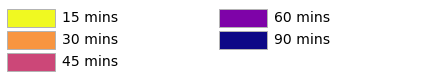

In [261]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)
# hex colors are stored in the column 0, maxspeed labels are stored in the column maxspeed
plot_utils.plot_colortable(colors=list(reversed(iso_colors)), names=[f'{i//60} mins' for i in trip_times], ncols=2, sort_colors=False)

# Shortest path - driving

Derive the shortest path between all combinations from workplace clusters to residential clusters

`osmnx.routing.shortest_path(G, orig, dest, *, weight='length', cpus=1)`
Solve shortest path from origin node(s) to destination node(s). This returns a list of lists of the nodes constituting the shortest path between each origin-destination pair.

Since we are only interested in the shortest travel time (seconds) instead of the shortest route, we can use `networkx.shortest_path_length(G, source=None, target=None, weight=None, method='dijkstra')` to get the shortest time from orig to dest

In [264]:
drive_route_times = driving.get_shortest_path_driving(G_car,orig = workplace_nodes[0],dest=None)
drive_route_times

{np.int64(258305981): 0,
 5118259982: 0.911401011182386,
 5683697730: 1.653943092178995,
 5683697728: 2.599012479785505,
 5118259978: 4.031682937774908,
 4604229240: 7.981543037333616,
 4604229260: 12.384105136009257,
 4604229261: 13.674530867975577,
 4604229233: 14.348895243466991,
 239826365: 14.455485878865225,
 1726563965: 15.782887749685376,
 4604229254: 17.75271935617484,
 4604229247: 18.374586993181833,
 4604229241: 20.341490666543866,
 258305979: 24.27688668299045,
 5683697731: 26.753203800246055,
 239832558: 28.499025292821294,
 1294427461: 29.139840028105432,
 626311920: 31.746118951920632,
 239832573: 33.20738551268695,
 2426217331: 33.58459544222393,
 246960838: 35.149922340627214,
 4604229255: 36.013599931235206,
 246961166: 36.17396207495932,
 239833256: 36.45128196291303,
 243670932: 36.86829787481398,
 246960848: 38.31325070095102,
 3118091525: 40.39590869186877,
 254668821: 40.99690022069184,
 4594224863: 41.162284503659436,
 246960843: 41.65103020380386,
 3109302810: 

<Axes: >

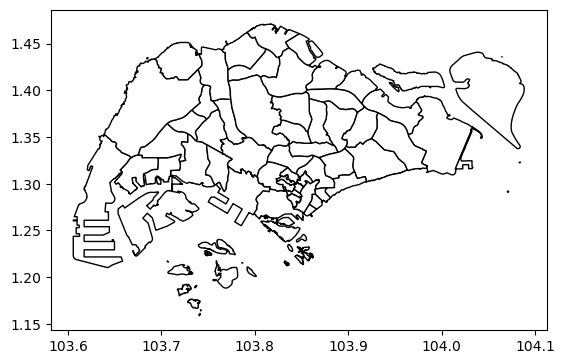

In [319]:
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
planningArea_shp.plot(fc='white',ec='k')

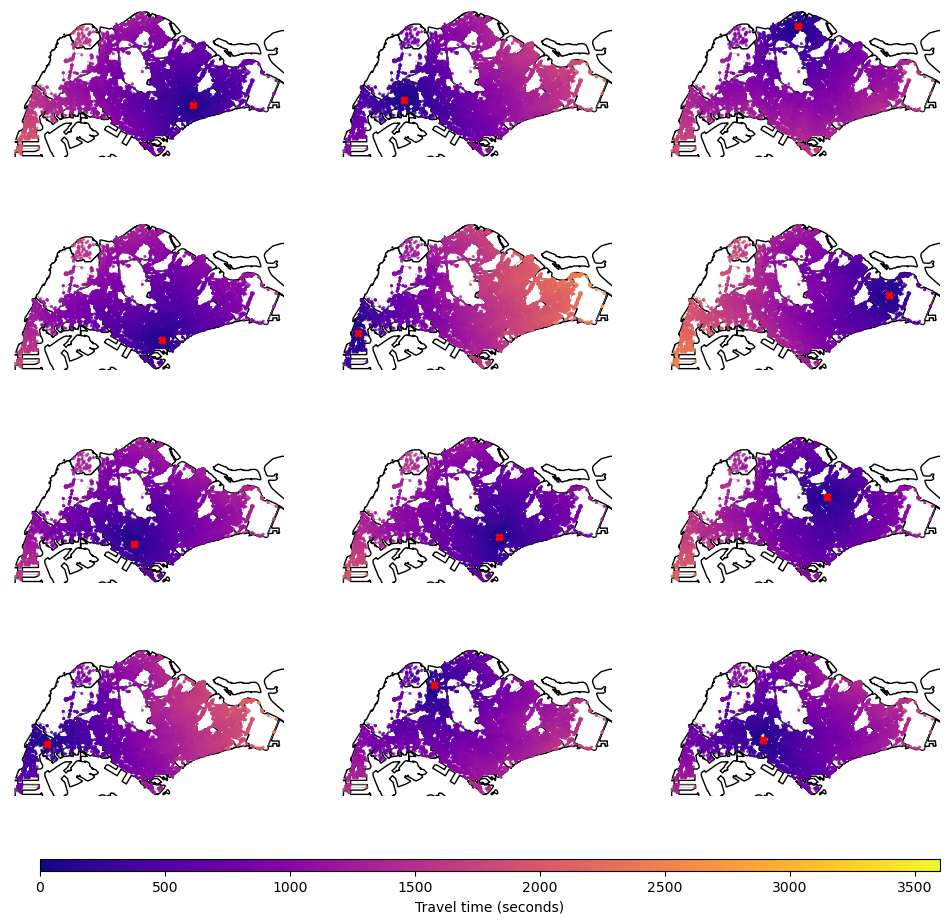

In [ ]:
iso_dir = os.path.join(r"data","isochrones")
if not os.path.exists(iso_dir):
    os.mkdir(iso_dir)
n_clusters = len(workplace_cluster.index)
ncols = 3
nrows = n_clusters//ncols
# define cbar 
cbar = plot_utils.get_colorbar(vmin=0,vmax=3600,cmap="plasma",plot=False)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols*4,nrows*3))
for i, ax in enumerate(axes.flatten()):
    # plot planning area boundary
    planningArea_shp.plot(fc='white',ec='k',ax=ax)
    # get attributes
    lat = workplace_cluster.loc[i,"latitude"]
    lon = workplace_cluster.loc[i,"longitude"]
    node_id = workplace_cluster.loc[i,"node_ID"]
    # plot isochrone
    drive_route_times = driving.get_shortest_path_driving(G_car,orig = node_id,dest=None,cbar=cbar,ax=ax)
    # save drive route times 
    # utils.pickle_data(drive_route_times,os.path.join(iso_dir,f'dry_isochrone_car_workClusters{i}.pkl'))
    # plot orig node
    ax.scatter(lon,lat,marker="X",c="r",s=25)
# plt.tight_layout()
# plot colorbar
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.75, 0.01]) # left, bottom, width, height
fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal', label='Travel time (seconds)')
fp_save = os.path.join(iso_dir,"dry_isochrone_car_workClusters.png")
plt.savefig(fp_save, bbox_inches = 'tight')
plt.show()

# Shortest path - public transport
- use OneMap API to do public transit routing from origin to destination
- simulate routing from all bus stop nodes to workplace clusters
- We need to create a road network for bus that reflects the bus speed limits - `bus_network`
- OD routing only needs to consider bus stops as D instead of every node in Singapore, as this is the final public transit for most places, don't need to consider walking in the OD journey, as pedestrians will not be affected by floods
- TODO:
    - modify `G_car` to `G_bus`. e.g. expressway = 70 - 90 km/h for cars; 60 km/h for buses
    - save all the routes from OD and its associated nodes **from bus routes only**. The assumption is that bus routes will only be affected by floods, walking and mrt transport will not be affected by floods too much. I guess we are not considering the impact of rains on mrt transport because we cannot prevent intense rainfall, but we can prevent intense floods

### G_bus

In [378]:
save_dir = os.path.join(os.getcwd(),"data")

filename = "SG_car_network.graphml"

G_bus = ox.load_graphml(os.path.join(save_dir,filename))

In [379]:
edges = ox.graph_to_gdfs(G_bus, nodes=False)
edges.head()

osmid  \
u        v          key                                                      
25451929 6749812859 0    [49961799, 718881456, 741164883, 754786742, 17...   
25455287 1637003462 0                                            150829205   
         2521018789 0                     [633215386, 74607482, 635109319]   
26777521 172424179  0                    [481674707, 654734557, 633179143]   
         1889379421 0         [643413273, 559564482, 640203517, 640203518]   

                               highway   lanes maxspeed  \
u        v          key                                   
25451929 6749812859 0         motorway       5     70.0   
25455287 1637003462 0    motorway_link       1     50.0   
         2521018789 0         motorway  [2, 3]     90.0   
26777521 172424179  0          primary       2     40.0   
         1889379421 0      residential       2     50.0   

                                                  name  oneway  ref reversed  \
u        v          key                                                        
25451929 6749812859 0               East Coast Parkway    True  ECP    False   
25455287 1637003462 0    Kallang Paya Lebar Expressway    True  NaN    False   
         2521018789 0               East Coast Parkway    True  ECP    False   
26777521 172424179  0                      Grange Road    True  NaN    False   
         1889379421 0                    Cuscaden Road   False  NaN    False   

                             length bridge  \
u        v          key                      
25451929 6749812859 0    765.027747    yes   
25455287 1637003462 0    629.055082    NaN   
         2521018789 0    652.575579    NaN   
26777521 172424179  0    113.995770    NaN   
         1889379421 0     86.667744    NaN   

                                                                  geometry  \
u        v          key                                                      
25451929 6749812859 0    LINESTRING (103.87254 1.29523, 103.87103 1.295...   
25455287 1637003462 0    LINESTRING (103.874 1.29544, 103.87413 1.2955,...   
         2521018789 0    LINESTRING (103.874 1.29544, 103.87438 1.29544...   
26777521 172424179  0    LINESTRING (103.82357 1.30398, 103.82359 1.303...   
         1889379421 0    LINESTRING (103.82357 1.30398, 103.82372 1.304...   

                         speed_kph  travel_time tunnel junction access width  
u        v          key                                                       
25451929 6749812859 0         70.0    39.344284    NaN      NaN    NaN   NaN  
25455287 1637003462 0         50.0    45.291966    NaN      NaN    NaN   NaN  
         2521018789 0         90.0    26.103023    NaN      NaN    NaN   NaN  
26777521 172424179  0         40.0    10.259619    NaN      NaN    NaN   NaN  
         1889379421 0         50.0     6.240078    NaN      NaN    NaN   NaN

In [ ]:
# if speed exceeds 60, replace it with 60 as that is the maximum bus speed
get_max_bus_speeds = lambda x: 60 if x > 60 else x
edges['']